In [4]:
import numpy as np
import sklearn as skl
from sklearn.preprocessing import OneHotEncoder
import scipy.io as scio
import scipy
import skimage as sk
from skimage import color
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import h5py
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.core import Flatten, Reshape, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18081611405308922888
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 7680170394
locality {
  bus_id: 1
}
incarnation: 8667516444632943526
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0"
]


# Load Datasets

Loads the SVHN and MNIST datasets. We'll be building a binary classifier that classifies an image as part of the MNIST dataset or SVHN dataset. 

In [6]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
mnist_train_X = mnist.train.images
mnist_test_X = mnist.test.images
mnist_train_y = mnist.train.labels
mnist_test_y = mnist.test.labels

In [8]:
svhn_train = scio.loadmat('svhn_train.mat')
svhn_test = scio.loadmat('svhn_test.mat')

In [9]:
svhn_train_X = svhn_train['X']
svhn_train_y = svhn_train['y']
svhn_test_X = svhn_test['X']
svhn_test_y = svhn_test['y']
encoder = OneHotEncoder()
svhn_train_y = encoder.fit_transform(svhn_train_y).todense()
svhn_test_y = encoder.fit_transform(svhn_test_y).todense()

# Preprocessing

We resize the SVHN images to 28 x 28

In [10]:
svhn_train_X = np.array([sk.img_as_float(scipy.misc.imresize(svhn_train_X[:, :, :, i], (28, 28, 3))) for i in range(svhn_train_X.shape[-1])])
svhn_test_X = np.array([sk.img_as_float(scipy.misc.imresize(svhn_test_X[:, :, :, i], (28, 28, 3))) for i in range(svhn_test_X.shape[-1])])

We resize the MNIST images to 28 x 28

In [11]:
mnist_train_X = mnist_train_X.reshape(mnist_train_X.shape[0], 28, 28, 1)
mnist_test_X = mnist_test_X.reshape(mnist_test_X.shape[0], 28, 28, 1)

In [12]:
stacked_mnist_train_X = np.stack((mnist_train_X, mnist_train_X, mnist_train_X), axis=3).reshape(mnist_train_X.shape[0], 28, 28, 3)
stacked_mnist_test_X = np.stack((mnist_test_X, mnist_test_X, mnist_test_X), axis=3).reshape(mnist_test_X.shape[0], 28, 28, 3)

# MNIST & SVHN Classifier: f
We define a classifier for both MNIST and SVHN for our cross domain mapping.

In [73]:
def f_model(pretrain=True):
    f = Sequential([
        Conv2D(64, (3, 3), input_shape=(28, 28, 3), padding='same'), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('relu'),
        Conv2D(128, (3, 3)), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('relu'),
        Conv2D(256, (3, 3)), 
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('tanh'),
        Conv2D(128, (4, 4), padding='same'),
#         BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Activation('tanh'),
    ])
    if pretrain:
        f.add(Conv2D(10, (1, 1)))
        f.add(Activation('softmax'))
        f.add(Flatten())
    return f

### Initialize f

In [74]:
f = f_model()
f.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [75]:
X_train = np.vstack((stacked_mnist_train_X, svhn_train_X))
X_test = np.vstack((stacked_mnist_test_X, svhn_test_X))
y_train = np.vstack((mnist_train_y, svhn_train_y))
y_test = np.vstack((mnist_test_y, svhn_test_y))
X_train, y_train = skl.utils.shuffle(X_train, y_train)
X_test, y_test = skl.utils.shuffle(X_test, y_test)

In [77]:
f.fit(X_train, y_train, epochs=2)

Epoch 1/2
128257/128257 [==============================] - 28s - loss: 0.2983 - acc: 0.9096    
Epoch 2/2
128257/128257 [==============================] - 26s - loss: 0.2012 - acc: 0.9398    


In [78]:
f.save_weights('fweights.h5')

### Validation

In [88]:
f.evaluate(X_test, y_test)

35744/36032 [============================>.] - ETA: 0s

[1.6469843772969492, 0.43675066607460034]

# Generator: g


In [82]:
def g_model():
    return Sequential([
        Conv2DTranspose(512, (4, 4), input_shape=(1, 1, 128), kernel_initializer='truncated_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(256, (5, 5), kernel_initializer='truncated_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(128, (9, 9), kernel_initializer='truncated_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2DTranspose(1, (13, 13), kernel_initializer='truncated_normal'),
        Activation('tanh'),
    ])

def extract_f(f_classifier):
    f = Sequential()
    for i in range(13):
        f.add(f_classifier.get_layer(index=i))
    return f

def discriminator():
    return Sequential([
        Conv2D(128, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_initializer='truncated_normal'),
        BatchNormalization(),  
        Activation('relu'),
        Conv2D(256, (3, 3), padding='same', kernel_initializer='glorot_normal'),
        BatchNormalization(),  
        Activation('relu'),
        Conv2D(512, (3, 3), padding='same', kernel_initializer='glorot_normal'),
        BatchNormalization(),  
        Activation('relu'),
        Conv2D(1, (4, 4), padding='valid', kernel_initializer='truncated_normal'),
        Activation('relu'),
        Flatten(),
        Dense(1),
        Activation('sigmoid'),
    ])
    
def generator(f, g):
    model = Sequential()
    model.add(f)
    model.add(g)
    return model

def trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [83]:
g = g_model()
f_baseline = extract_f(f)
f_baseline.trainable = False
G = generator(f_baseline, g)
G.layers[0].trainable = False
D = discriminator()

In [84]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_52 (Sequential)   (None, 1, 1, 128)         895232    
_________________________________________________________________
sequential_51 (Sequential)   (None, 28, 28, 1)         7005697   
Total params: 7,900,929
Trainable params: 7,003,905
Non-trainable params: 897,024
_________________________________________________________________


In [ ]:
G.load_weights('G.h5')
D.load_weights('D.h5')

# Training G and D

In [85]:
def train(g, d, mnist_X, svhn_X, epochs=1):
    g_d = generator_with_discriminator(g, d)
    
    for i in range(3):
        print('Iteration {}'.format(i))
        # Generate MNIST examples for SVHN for training
        g_train_data = g.predict(svhn_X)
        
        # Label as real or fake 
        real_labels, fake_labels = np.zeros(mnist_X.shape[0]), np.ones(svhn_X.shape[0])
        train_data, train_labels = np.vstack((mnist_X, g_train_data)), np.hstack((real_labels, fake_labels))
        train_data, train_labels = skl.utils.shuffle(train_data, train_labels)
        
        # Train discriminator on this real/fake data
        print('Training Discriminator')
        d.trainable = True
        d = discriminator()
        d.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
        d.fit(train_data, train_labels, batch_size=100, epochs=1)
        
        # Train generator based on the outputs of the discriminator
        print('Training Generator')
        g_d = generator_with_discriminator(g, d)
#         d.trainable = False
        g_d.layers[1].trainable = False
        g_d.compile(loss=loss_function(svhn_X, g), optimizer='adam', metrics=['accuracy'])
        g_d.fit(svhn_X, np.zeros(svhn_X.shape[0]), batch_size=100, epochs=2)
        
        g.save_weights('G.h5')
        d.save_weights('D.h5')
    return g, d

def loss_function(svhn_X, g):
    class_true = f.predict(svhn_X)
    def loss(y_true, y_pred):
        preds = g.predict(svhn_X)
        stacked_preds = np.stack((preds, preds, preds), axis=3).reshape(preds.shape[0], 28, 28, 3)
        class_pred = f.predict(stacked_preds)
        loss_gan = tf.reduce_mean(keras.losses.mean_squared_error(y_true, y_pred))
        loss_const = tf.reduce_mean(keras.losses.mean_squared_error(class_true, class_pred))
        return 0.5 * loss_gan + 0.3 * loss_const
    return loss

def generator_with_discriminator(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

In [86]:
# D = discriminator()
G, D = train(G, D, mnist_test_X[:10000], svhn_test_X[:10000])

Iteration 0
Training Discriminator
Epoch 1/1
20000/20000 [==============================] - 34s - loss: 0.0098 - acc: 0.9954    
Training Generator
Epoch 1/2
10000/10000 [==============================] - 18s - loss: 0.0331 - acc: 0.9902    
Epoch 2/2
10000/10000 [==============================] - 16s - loss: 0.0283 - acc: 1.0000    
Iteration 1
Training Discriminator
Epoch 1/1
20000/20000 [==============================] - 34s - loss: 0.0078 - acc: 0.9974    
Training Generator
Epoch 1/2
10000/10000 [==============================] - 18s - loss: 0.1069 - acc: 0.8300    
Epoch 2/2
10000/10000 [==============================] - 16s - loss: 0.0219 - acc: 1.0000    
Iteration 2
Training Discriminator
Epoch 1/1
20000/20000 [==============================] - 34s - loss: 8.0446 - acc: 0.4944    
Training Generator
Epoch 1/2
10000/10000 [==============================] - 18s - loss: 0.0048 - acc: 1.0000    
Epoch 2/2
10000/10000 [==============================] - 17s - loss: 0.0048 - acc: 1.0

array([[ 0.07157574],
       [ 0.07730179],
       [ 0.07636562],
       [ 0.07624192],
       [ 0.07421757],
       [ 0.07597011],
       [ 0.07600918],
       [ 0.07713066],
       [ 0.07583241],
       [ 0.07444246]], dtype=float32)

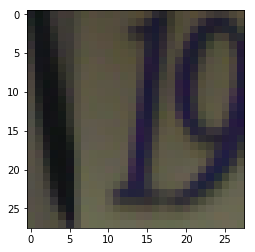

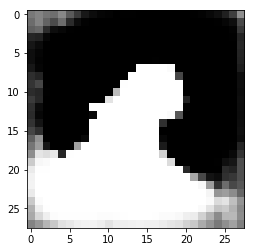

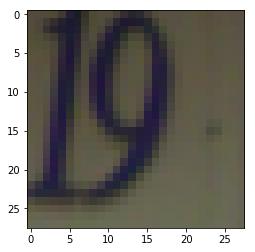

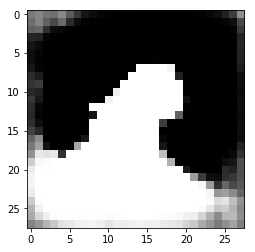

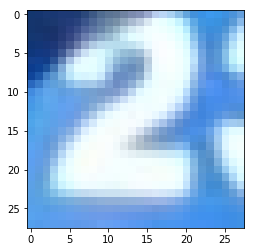

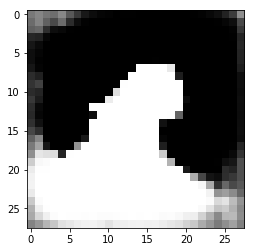

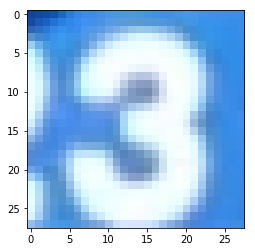

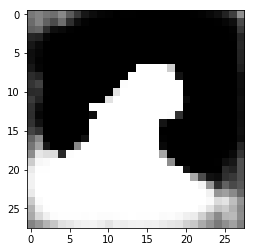

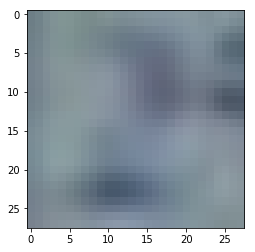

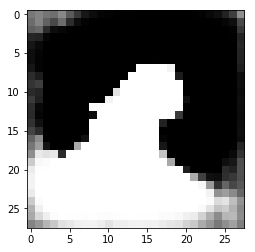

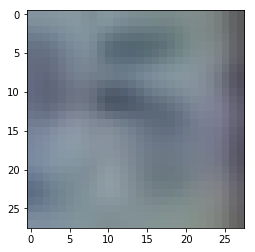

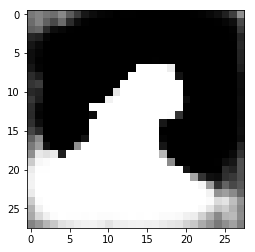

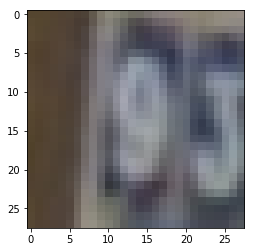

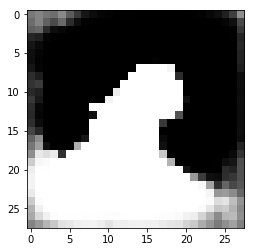

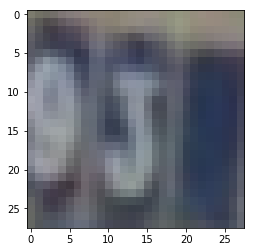

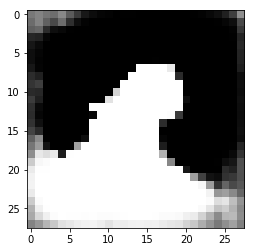

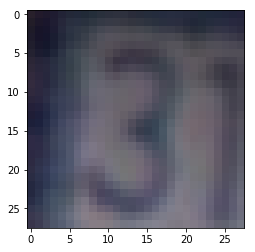

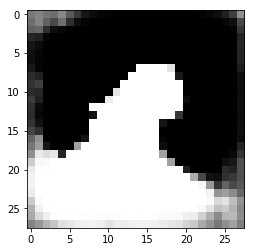

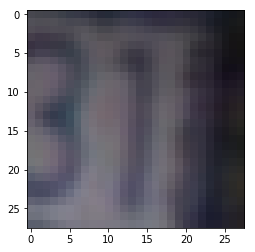

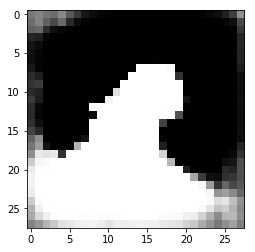

In [87]:
g_images = G.predict(svhn_train_X[:10])
for i in range(10):
    plt.figure()
    plt.imshow(svhn_train_X[i])
    plt.figure()
    plt.imshow(g_images[i][:, :, 0], cmap='gray')
D.predict(g_images)

[<tf.Variable 'conv2d_253/kernel:0' shape=(3, 3, 1, 128) dtype=float32_ref>,
 <tf.Variable 'conv2d_253/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_221/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_221/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv2d_254/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>,
 <tf.Variable 'conv2d_254/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_222/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_222/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'conv2d_255/kernel:0' shape=(3, 3, 256, 512) dtype=float32_ref>,
 <tf.Variable 'conv2d_255/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_223/gamma:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'batch_normalization_223/beta:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'conv2d_256/kernel:0' shape=(4, 4, 512, 1) dtype=float32_ref>,
 <tf

In [162]:
f.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_236 (Conv2D)          (None, 28, 28, 64)        1792      
_________________________________________________________________
batch_normalization_199 (Bat (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
activation_319 (Activation)  (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_237 (Conv2D)          (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normalization_200 (Bat (None, 12, 12, 128)       512       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 128)         0         
__________

In [90]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_52 (Sequential)   (None, 1, 1, 128)         895232    
_________________________________________________________________
sequential_51 (Sequential)   (None, 28, 28, 1)         7005697   
Total params: 7,900,929
Trainable params: 7,003,905
Non-trainable params: 897,024
_________________________________________________________________
